In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import RobustScaler, OneHotEncoder, QuantileTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import scipy.sparse as sp


from sklearn.model_selection import train_test_split

2025-06-05 22:11:41.191068: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load and prepare data
df = pd.read_csv('/Users/user/Downloads/TrafficNG/traffic_weather_data_lagos.csv', parse_dates=['timestamp'])
df.sort_values('timestamp', inplace=True)



In [3]:
# Convert 'distance_km' to numeric
df['distance_km'] = pd.to_numeric(df['distance_km'], errors='coerce')

# Convert 'timestamp' to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


In [4]:
# Handle missing values - Fill weather-related missing values with median
weather_cols = ['temperature_c', 'humidity_percent', 'wind_speed_ms', 'rain_1h_mm', 'rain_3h_mm','visibility_meters','pressure_hpa','wind_direction_degrees','cloud_coverage_percent']
df[weather_cols] = df[weather_cols].fillna(df[weather_cols].median())

# Remove duplicates
#df_raw = df_raw.drop_duplicates()

In [5]:
# Feature engineering
features = df.drop(columns=['traffic_ratio', 'timestamp'])
target = df['traffic_ratio']


# Preprocessing pipeline
numerical_features = ['num_alternative_routes', 'visibility_meters', 'duration_in_traffic_mins',
                     'duration_normal_mins', 'distance_meters', 'route_complexity', 'hour_of_day',
                     'rain_1h_mm', 'pressure_hpa', 'wind_direction_degrees', 'cloud_coverage_percent',
                     'wind_speed_ms', 'temperature_c', 'humidity_percent']
categorical_features = ['origin','destination','weather_condition', 'day_of_week']



In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)  # Modified here
    ])

In [7]:

# Corrected preprocessing
X = preprocessor.fit_transform(features)  # Removed .toarray()
y = target.values

In [8]:
# Train-test split with time-based validation
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train_orig, y_test_orig = y[:split_idx], y[split_idx:]


In [9]:
# Target transformation using QuantileTransformer
qt = QuantileTransformer(output_distribution='normal', random_state=42)
y_train = qt.fit_transform(y_train_orig.reshape(-1, 1)).flatten()
y_test = qt.transform(y_test_orig.reshape(-1, 1)).flatten()

In [10]:

# Target transformation using QuantileTransformer
qt = QuantileTransformer(output_distribution='normal', random_state=42)
y_train = qt.fit_transform(y_train_orig.reshape(-1, 1)).flatten()
y_test = qt.transform(y_test_orig.reshape(-1, 1)).flatten()


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)


In [11]:
# LSTM Model with sequence creation
def create_sequences(data, targets, window_size=24):
    X_seq, y_seq = [], []
    for i in range(len(data)-window_size):
        X_seq.append(data[i:i+window_size])
        y_seq.append(targets[i+window_size])
    return np.array(X_seq), np.array(y_seq)

window_size = 24  # 24 timesteps window
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)

lstm = Sequential([
    LSTM(64, activation='tanh', recurrent_activation='sigmoid', 
         input_shape=(window_size, X_train.shape[1])),
    Dense(1)
])
lstm.compile(optimizer=Adam(0.001), loss='mse')
lstm.fit(X_train_seq, y_train_seq, epochs=2, batch_size=32,
         validation_data=(X_test_seq, y_test_seq), 
         verbose=1, callbacks=[early_stopping])
lstm_pred = qt.inverse_transform(lstm.predict(X_test_seq).reshape(-1, 1)).flatten()


Epoch 1/20


2025-06-05 22:11:46.632757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-06-05 22:11:46.634279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-06-05 22:11:46.635387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

709/709 [==============================] - ETA: 0s - loss: 0.2539

2025-06-05 22:11:56.642002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-06-05 22:11:56.643334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-06-05 22:11:56.644770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

709/709 [==============================] - 11s 13ms/step - loss: 0.2539 - val_loss: 0.3138
Epoch 2/20
709/709 [==============================] - 8s 11ms/step - loss: 0.1657 - val_loss: 0.2885
Epoch 3/20
709/709 [==============================] - 7s 9ms/step - loss: 0.1462 - val_loss: 0.2686
Epoch 4/20
709/709 [==============================] - 7s 9ms/step - loss: 0.1352 - val_loss: 0.2561
Epoch 5/20
709/709 [==============================] - 7s 10ms/step - loss: 0.1248 - val_loss: 0.2625
Epoch 6/20
709/709 [==============================] - 7s 10ms/step - loss: 0.1182 - val_loss: 0.2618
Epoch 7/20
709/709 [==============================] - 7s 10ms/step - loss: 0.1123 - val_loss: 0.2600
Epoch 8/20
709/709 [==============================] - 7s 10ms/step - loss: 0.1072 - val_loss: 0.2586
Epoch 9/20
 16/177 [=>............................] - ETA: 0s  

2025-06-05 22:12:53.790531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-06-05 22:12:53.792390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-06-05 22:12:53.793562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

177/177 [==============================] - 1s 4ms/step


In [12]:
# --- DNN Model ---
dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
dnn.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
dnn.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)
dnn_pred = qt.inverse_transform(dnn.predict(X_test).reshape(-1, 1)).flatten()

178/178 [==============================] - 0s 834us/step


In [13]:
# SVR Model
scaler = StandardScaler()
X_train_svr = scaler.fit_transform(X_train)
X_test_svr = scaler.transform(X_test)

svr = SVR(kernel='rbf', C=100, epsilon=0.1)
svr.fit(X_train_svr, y_train)

svr_pred = qt.inverse_transform(svr.predict(X_test_svr).reshape(-1, 1)).flatten()


In [ ]:
# Model Evaluation
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Evaluation:")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R²: {r2_score(y_true, y_pred):.4f}")

y_test_lstm = y_test_orig[window_size:]
print("="*50)


evaluate_model(y_test_lstm, lstm_pred, "LSTM")
evaluate_model(y_test_orig, dnn_pred, "DNN")
evaluate_model(y_test_orig, svr_pred, "SVR")
print("="*50)


LSTM Evaluation:
RMSE: 0.1139
MAE: 0.0682
R²: 0.6969

DNN Evaluation:
RMSE: 0.0431
MAE: 0.0276
R²: 0.9571

SVR Evaluation:
RMSE: 0.0390
MAE: 0.0199
R²: 0.9648


In [17]:
# Function to plot actual vs predicted values
def plot_actual_vs_predicted(y_true, y_pred, model_name, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    plt.plot(y_true, label='Actual', color='blue', alpha=0.7)
    plt.plot(y_pred, label='Predicted', color='red', alpha=0.7)
    plt.title(f'{model_name} - Actual vs Predicted Traffic Ratio')
    plt.xlabel('Time Steps')
    plt.ylabel('Traffic Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()

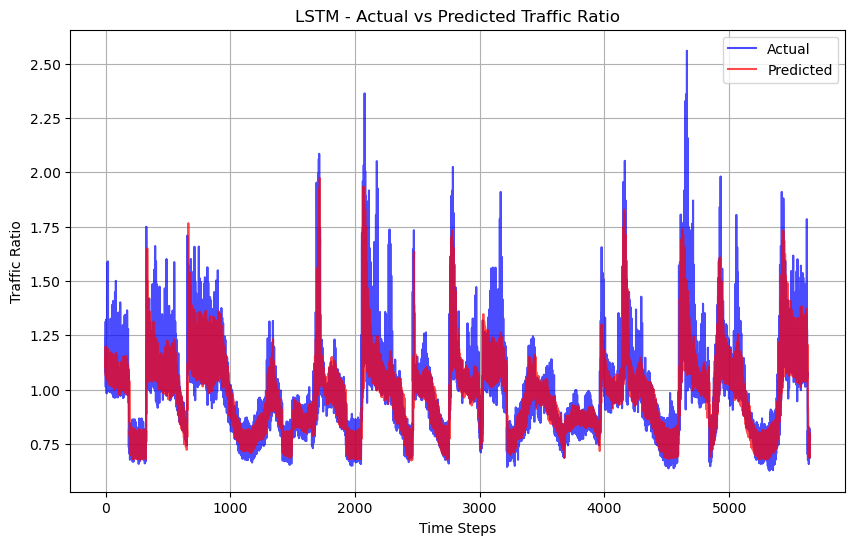

In [18]:
plot_actual_vs_predicted(y_test_lstm, lstm_pred, "LSTM")

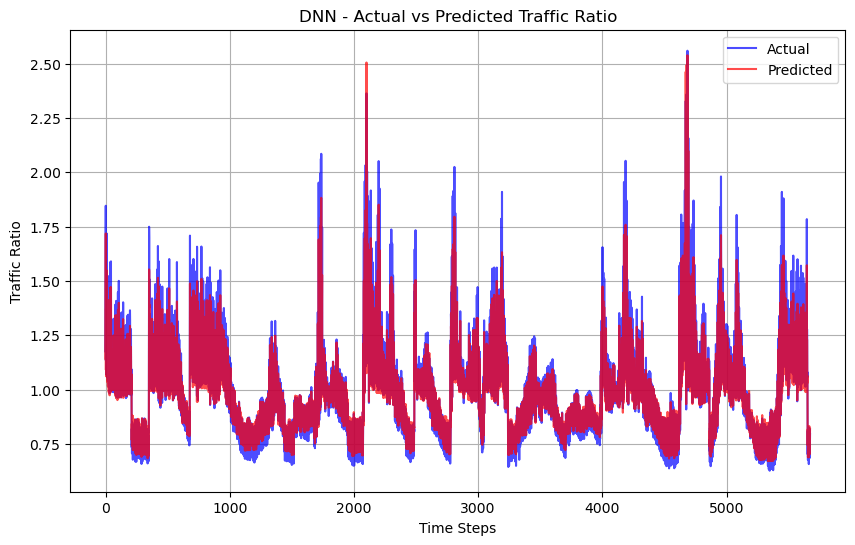

In [19]:
# Plot for DNN
plot_actual_vs_predicted(y_test_orig, dnn_pred, "DNN")

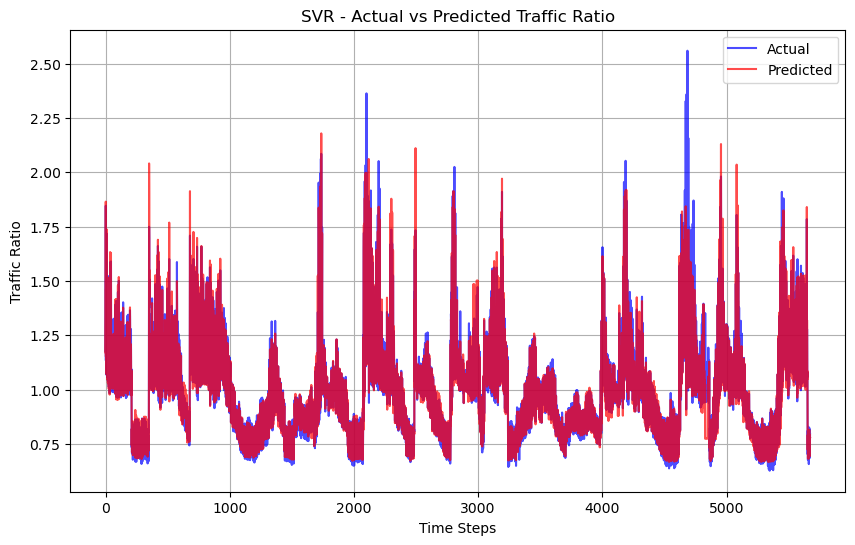

In [20]:
plot_actual_vs_predicted(y_test_orig, svr_pred, "SVR")

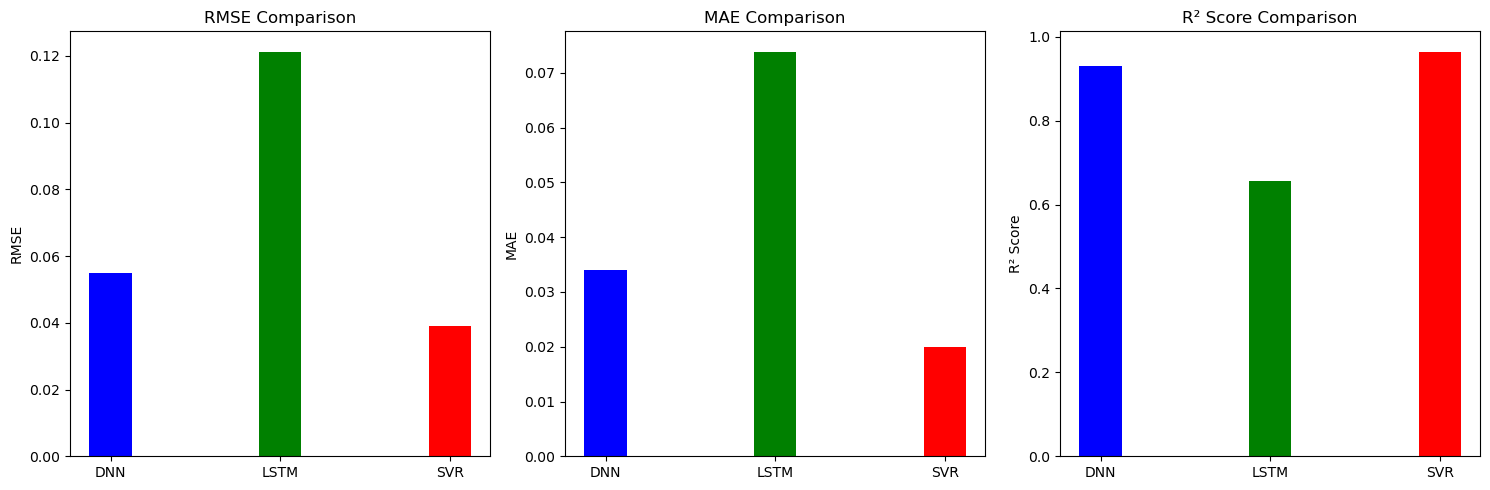

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and metrics
models = ["DNN", "LSTM", "SVR"]
rmse_values = [0.0549, 0.1213, 0.0390]
mae_values = [0.0341, 0.0739, 0.0199]
r2_values = [0.9303, 0.6566, 0.9648]

# Set width of bars
bar_width = 0.25
x = np.arange(len(models))

# Create figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE Plot
axes[0].bar(x, rmse_values, color=['blue', 'green', 'red'], width=bar_width)
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].set_title("RMSE Comparison")
axes[0].set_ylabel("RMSE")

# MAE Plot
axes[1].bar(x, mae_values, color=['blue', 'green', 'red'], width=bar_width)
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].set_title("MAE Comparison")
axes[1].set_ylabel("MAE")

# R² Score Plot
axes[2].bar(x, r2_values, color=['blue', 'green', 'red'], width=bar_width)
axes[2].set_xticks(x)
axes[2].set_xticklabels(models)
axes[2].set_title("R² Score Comparison")
axes[2].set_ylabel("R² Score")

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [28]:
#import pickle

In [29]:
#lstm.save('lstm_model.h5')

In [30]:
#from tensorflow.keras.models import save_model

# Save the DNN model in Keras .h5 format
#save_model(dnn, 'dnn_model.h5')  # Saves architecture, weights, and optimizer state

In [31]:
#import pickle

# Save the SVR model and both scalers in a single .pkl file
#with open('svr_model_with_scalers.pkl', 'wb') as f:
#    pickle.dump({
 #       'svr_model': svr,          # Trained SVR model
  #      'feature_scaler': scaler,  # StandardScaler for features (X)
   #     'target_scaler': qt        # Scaler for target (y)
   # }, f)

In [32]:
#import pickle

# Save all preprocessing objects in one file
#preprocessing_data = {
    # Shared preprocessing
 #   'qt': qt,  # Target scaler (used by all models)
    
    # For LSTM
  #  'lstm_window_size': 24,  # Your LSTM sequence window size
    
    # For SVR
   # 'feature_scaler': scaler,  # StandardScaler for SVR features
    
    # For DNN (if different preprocessing is needed)
    #'dnn_feature_scaler': None  # Replace if DNN uses different scaling
#}

#with open('preprocessing.pkl', 'wb') as f:
 #   pickle.dump(preprocessing_data, f)

In [33]:
# When loading (example usage for each model):
#with open('preprocessing.pkl', 'rb') as f:
 #   prep = pickle.load(f)

# LSTM usage:
#qt = prep['qt']
#window_size = prep['lstm_window_size']

# SVR usage:
#svr_scaler = prep['feature_scaler']  # StandardScaler for features
#qt = prep['qt']  # For inverse transform

# DNN usage:
#qt = prep['qt']
# (If DNN needs feature scaling, use prep['dnn_feature_scaler'])

In [38]:
# For LSTM/DNN models, replace model.save() with:
#tf.keras.models.save_model(
 #   dnn,
  #  'dnn_model.h5',
   ##include_optimizer=True
#)



In [39]:
# For SVR model and preprocessors:
#import joblib
#joblib.dump(svr, 'svr_model.pkl')
#joblib.dump(preprocessor, 'preprocessor.pkl')
#joblib.dump(qt, 'quantile_transformer.pkl')


In [41]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.preprocessing import QuantileTransformer
import joblib

# 1. Recreate your preprocessor
numerical_features = ['num_alternative_routes', 'visibility_meters', 'duration_in_traffic_mins',
                     'duration_normal_mins', 'distance_meters', 'route_complexity', 'hour_of_day',
                     'rain_1h_mm', 'pressure_hpa', 'wind_direction_degrees', 'cloud_coverage_percent',
                     'wind_speed_ms', 'temperature_c', 'humidity_percent']
categorical_features = ['origin','destination','weather_condition', 'day_of_week']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Fit with sample data or your actual training data
sample_df = pd.DataFrame({col: [0] for col in numerical_features + categorical_features})
preprocessor.fit(sample_df)

# 2. Recreate your SVR model
svr_model = SVR(kernel='rbf', C=100, epsilon=0.1)
# Fit with your actual training data
# svr_model.fit(X_train, y_train)

# 3. Recreate QuantileTransformer
qt = QuantileTransformer(output_distribution='normal', random_state=42)
# Fit with your actual y data
# qt.fit(y_train.reshape(-1, 1))

# Save using joblib (more reliable than pickle)
joblib.dump(preprocessor, '/Users/user/Documents/Traffic Deployment LAG/models/preprocessor.pkl')
joblib.dump(svr_model, '/Users/user/Documents/Traffic Deployment LAG/models/svr_model.pkl')
joblib.dump(qt, '/Users/user/Documents/Traffic Deployment LAG/models/quantile_transformer.pkl')

['/Users/user/Documents/Traffic Deployment LAG/models/quantile_transformer.pkl']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import RobustScaler, OneHotEncoder, QuantileTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import scipy.sparse as sp


from sklearn.model_selection import train_test_split

# Load and prepare data
df = pd.read_csv('/Users/user/Downloads/TrafficNG/traffic_weather_data_lagos.csv', parse_dates=['timestamp'])
df.sort_values('timestamp', inplace=True)

# Convert 'distance_km' to numeric
df['distance_km'] = pd.to_numeric(df['distance_km'], errors='coerce')

# Convert 'timestamp' to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Handle missing values - Fill weather-related missing values with median
weather_cols = ['temperature_c', 'humidity_percent', 'wind_speed_ms', 'rain_1h_mm', 'rain_3h_mm','visibility_meters','pressure_hpa','wind_direction_degrees','cloud_coverage_percent']
df[weather_cols] = df[weather_cols].fillna(df[weather_cols].median())

# Remove duplicates
#df_raw = df_raw.drop_duplicates()

# Feature engineering
features = df.drop(columns=['traffic_ratio', 'timestamp'])
target = df['traffic_ratio']


# Preprocessing pipeline
numerical_features = ['num_alternative_routes', 'visibility_meters', 'duration_in_traffic_mins',
                     'duration_normal_mins', 'distance_meters', 'route_complexity', 'hour_of_day',
                     'rain_1h_mm', 'pressure_hpa', 'wind_direction_degrees', 'cloud_coverage_percent',
                     'wind_speed_ms', 'temperature_c', 'humidity_percent']
categorical_features = ['origin','destination','weather_condition', 'day_of_week']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)  # Modified here
    ])


# Corrected preprocessing
X = preprocessor.fit_transform(features)  # Removed .toarray()
y = target.values
# Train-test split with time-based validation
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train_orig, y_test_orig = y[:split_idx], y[split_idx:]

# Target transformation using QuantileTransformer
qt = QuantileTransformer(output_distribution='normal', random_state=42)
y_train = qt.fit_transform(y_train_orig.reshape(-1, 1)).flatten()
y_test = qt.transform(y_test_orig.reshape(-1, 1)).flatten()

# LSTM Model with sequence creation
def create_sequences(data, targets, window_size=24):
    X_seq, y_seq = [], []
    for i in range(len(data)-window_size):
        X_seq.append(data[i:i+window_size])
        y_seq.append(targets[i+window_size])
    return np.array(X_seq), np.array(y_seq)

window_size = 24  # 24 timesteps window
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)

lstm = Sequential([
    LSTM(64, activation='tanh', recurrent_activation='sigmoid', 
         input_shape=(window_size, X_train.shape[1])),
    Dense(1)
])
lstm.compile(optimizer=Adam(0.001), loss='mse')
lstm.fit(X_train_seq, y_train_seq, epochs=2, batch_size=32,
         validation_data=(X_test_seq, y_test_seq), 
         verbose=1, callbacks=[early_stopping])
lstm_pred = qt.inverse_transform(lstm.predict(X_test_seq).reshape(-1, 1)).flatten()

# --- DNN Model ---
dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
dnn.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
dnn.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)
dnn_pred = qt.inverse_transform(dnn.predict(X_test).reshape(-1, 1)).flatten()

# SVR Model
scaler = StandardScaler()
X_train_svr = scaler.fit_transform(X_train)
X_test_svr = scaler.transform(X_test)

svr = SVR(kernel='rbf', C=100, epsilon=0.1)
svr.fit(X_train_svr, y_train)

svr_pred = qt.inverse_transform(svr.predict(X_test_svr).reshape(-1, 1)).flatten()

# Model Evaluation
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Evaluation:")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R²: {r2_score(y_true, y_pred):.4f}")

y_test_lstm = y_test_orig[window_size:]
print("="*50)


evaluate_model(y_test_lstm, lstm_pred, "LSTM")
evaluate_model(y_test_orig, dnn_pred, "DNN")
evaluate_model(y_test_orig, svr_pred, "SVR")
print("="*50)

